<h1><center>Imputation on Rainfall data via Machine Learning</center></h1>
<h2><center>By: Ng Kien Loong</center></h2>
<hr>

In [1]:
# Importing the basic libraries 
from math import sqrt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings          
warnings.filterwarnings("ignore")

In [2]:
# Import rainfall dataset
filepath = r'TaburanHujanKelajuanAnginKelembapanRadiasiGlobal.xlsx'

In [3]:
# Initializing the dataframe
rainfall_petaling_jaya = pd.read_excel(filepath, sheet_name="PJ")
rainfall_subang = pd.read_excel(filepath, sheet_name="Subang")

In [4]:
# Create copies of dataframe
df_pj = rainfall_petaling_jaya.copy()
df_sb = rainfall_subang.copy()

# 1. Data Preparation

## Preprocessing

Arrange the dataset into a proper format. Firstly, by extracting the useful information.

In [5]:
df_pj.drop(index=range(2688, len(df_pj)), inplace=True)
df_pj.drop(index=range(11), inplace=True)

df_sb.drop(index=range(2688, len(df_sb)), inplace=True)
df_sb.drop(index=range(11), inplace=True)

Renaming the columns, while reset the index.

In [6]:
df_pj = df_pj.rename(columns={'JABATAN METEOROLOGI MALAYSIA':'stnno',
                                'Unnamed: 1':'year', 
                                'Unnamed: 2':'month', 
                                'Unnamed: 3':'day',
                                'Unnamed: 4':'rainfall', 
                                'Unnamed: 5':'mean_wind', 
                                'Unnamed: 6':'mean_humidity', 
                                'Unnamed: 7':'solar_radiation'})
df_pj.reset_index(inplace = True, drop=True)

df_sb = df_sb.rename(columns={'JABATAN METEOROLOGI MALAYSIA':'stnno',
                                'Unnamed: 1':'year', 
                                'Unnamed: 2':'month', 
                                'Unnamed: 3':'day',
                                'Unnamed: 4':'rainfall', 
                                'Unnamed: 5':'mean_wind', 
                                'Unnamed: 6':'mean_humidity', 
                                'Unnamed: 7':'solar_radiation'})
df_sb.reset_index(inplace = True, drop=True)

## Feature Extraction

Convert negative and non-numeric value into missing value, <code>nan</code>.

In [7]:
def convert_to_nan(df):
    
    df['rainfall'] = pd.to_numeric(df['rainfall'], errors='coerce')
    df.loc[df['rainfall'] < 0, 'rainfall'] = np.nan
    
    df['mean_wind'] = pd.to_numeric(df['mean_wind'], errors='coerce')
    df.loc[df['mean_wind'] < 0, 'mean_wind'] = np.nan

    df['mean_humidity'] = pd.to_numeric(df['mean_humidity'], errors='coerce')
    df.loc[df['mean_humidity'] < 0, 'mean_humidity'] = np.nan

    df['solar_radiation'] = pd.to_numeric(df['solar_radiation'], errors='coerce')
    df.loc[df['solar_radiation'] < 0, 'solar_radiation'] = np.nan
        
convert_to_nan(df_pj)
convert_to_nan(df_sb)

Convert feature values into <code>float64</code> data type for higher precision.

In [8]:
def convert_float64(df):
    
    df['rainfall'] = np.float64(df['rainfall'])
    df['mean_wind'] = np.float64(df['mean_wind'])
    df['mean_humidity'] = np.float64(df['mean_humidity'])
    df['solar_radiation'] = np.float64(df['solar_radiation'])

convert_float64(df_pj)
convert_float64(df_sb)

We will be focusing on station Subang dataset for rainfall imputation.

In [9]:
df = df_sb.copy()

Concatenate <code>rainfall</code> from station Petaling Jaya as a feature for station Subang.<br>
As we can retrieve the rainfall information from neighborhood station.
Therefore, we use <code>rainfall_pj</code> as a feature in station Subang dataset.

In [10]:
df['rainfall_pj'] = df_pj['rainfall']

## Exploratory Data Analysis

Let's find out the rows and columns in this dataset.

In [11]:
print(df.shape)

(2677, 9)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2677 entries, 0 to 2676
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   stnno            2677 non-null   object 
 1   year             2677 non-null   object 
 2   month            2677 non-null   object 
 3   day              2677 non-null   object 
 4   rainfall         2502 non-null   float64
 5   mean_wind        2665 non-null   float64
 6   mean_humidity    239 non-null    float64
 7   solar_radiation  2575 non-null   float64
 8   rainfall_pj      2500 non-null   float64
dtypes: float64(5), object(4)
memory usage: 188.4+ KB


In [13]:
df.describe()

,rainfall,mean_wind,mean_humidity,solar_radiation,rainfall_pj
count,2502.000000,2665.000000,239.000000,2575.000000,2500.000000
mean,8.618825,7.049081,17.464854,18.470757,10.490680
std,15.746907,19.809720,30.537242,4.744735,18.326525
min,0.000000,0.500000,0.800000,1.590000,0.000000
25%,0.000000,1.300000,1.300000,15.250000,0.000000
50%,0.800000,1.600000,1.600000,18.700000,1.200000
75%,10.000000,1.900000,2.000000,21.985000,13.450000
max,109.600000,93.000000,85.600000,30.100000,130.400000


Let us observe the rainfall amount with its missing values throughout the year 2009 for both station Subang and Petaling Jaya.

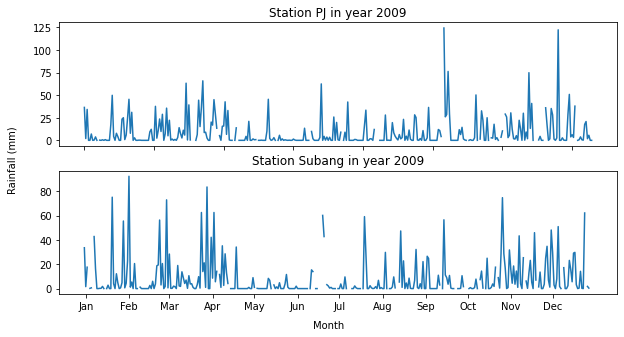

In [14]:
def plot_graph(ax, df, year):
    df_year = df[df["year"] == year]
    x = range(len(df_year))
    y = df_year['rainfall']
    ax.plot(x,y)

month_starts = [1,32,61,92,122,153,183,214,245,275,306,336]
month_names = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']

fig = plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

plot_graph(ax1, df_pj, 2009)
plot_graph(ax2, df_sb, 2009)

ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
ax1.title.set_text('Station PJ in year 2009')

ax2.set_xticks(month_starts)
ax2.set_xticklabels(month_names)
ax2.title.set_text('Station Subang in year 2009')

fig.text(0.5, 0.04, 'Month', ha='center', va='center')
fig.text(0.06, 0.5, 'Rainfall (mm)', ha='center', va='center', rotation='vertical')
fig.set_size_inches(10,5)
plt.show()

## Feature Engineering

The feature, <code>stnno</code> will not be useful for learning, and it is removed as well. <br>
We also realise that <code>mean_humidity</code> consists majority of missing values, as it would not be useful for training, and the following feature is removed. <br>

In [15]:
del df['stnno']

print(sum(df['mean_humidity'].isna()), 'rows of missing values in "mean_humidity" have removed.')
del df['mean_humidity']

2438 rows of missing values in "mean_humidity" have removed.


Since we are imputing missing values for <code>rainfall</code>, but missing values in features might affect the inaccuracy of the machine learning model. <br>
However, the rows of features that consist of missing values is removed, and the rainfall of the particular date is not being imputed. 

In [16]:
print(sum(df['mean_wind'].isna()), 'rows of missing values in "mean_wind" have removed.')
print(sum(df['solar_radiation'].isna()), 'rows of missing values in "solar_radiation" have removed.')
df.drop(df[df.mean_wind.isna()].index, inplace = True)
df.drop(df[df.solar_radiation.isna()].index, inplace = True)

# Reset the index
df.reset_index(inplace = True, drop = True)

12 rows of missing values in "mean_wind" have removed.
102 rows of missing values in "solar_radiation" have removed.


We would like to consider on the interaction deletion for missing rainfall data for both station.<br>
Hence, by removing missing rainfall data on station PJ, as the feature cannot be missing in order to predict the target.

In [17]:
print(sum(df['rainfall_pj'].isna()), "rows of missing values in 'rainfall_pj' have removed.")
df.drop(df[df.rainfall_pj.isna()].index, inplace = True)

171 rows of missing values in 'rainfall_pj' have removed.


Now, we look at the features depict the variation in the data distribution. <br>
For the 4 major attributes used:- <br>
<code>mean_wind</code> <br>
<code>solar_radiation</code> <br>
<code>rainfall_pj</code> <br>
<code>rainfall</code>

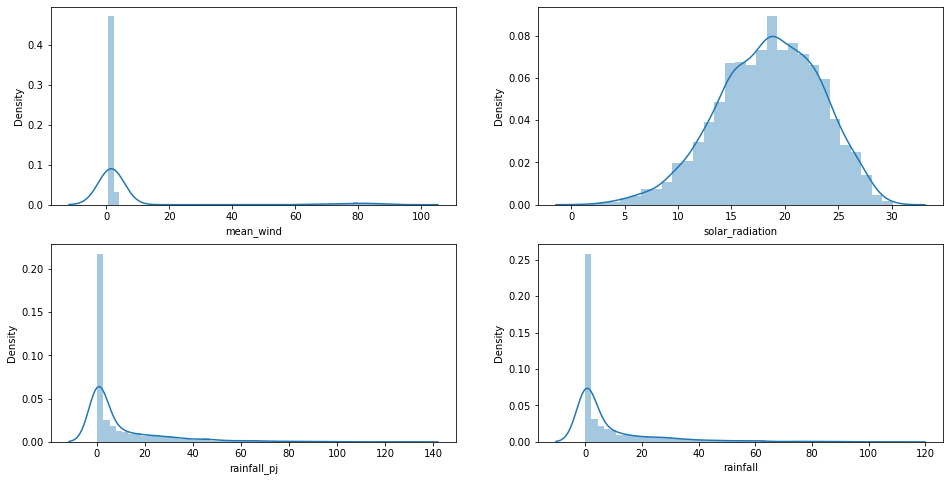

In [18]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df['mean_wind'])
plt.subplot(2,2,2)
sns.distplot(df['solar_radiation'])
plt.subplot(2,2,3)
sns.distplot(df['rainfall_pj'])
plt.subplot(2,2,4)
sns.distplot(df['rainfall'])
plt.show()

Drop <code>mean_wind</code> > 20 (outliers).

In [19]:
## Find rows of wind speed more than 20

df.drop(df[df['mean_wind'] > 20].index, inplace=True)

Further investigation on <code>mean_wind</code> by using boxplot to eliminate the remaining outliers.

<AxesSubplot:xlabel='mean_wind'>

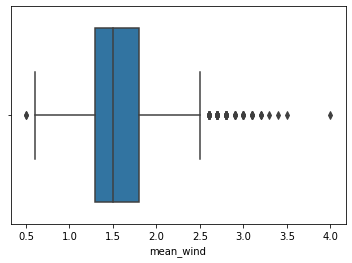

In [20]:
sns.boxplot(df['mean_wind'])

In [21]:
df.drop(df[df['mean_wind'] < 0.5].index, inplace = True)
df.drop(df[df['mean_wind'] > 2.5].index, inplace = True)

Investigation on <code>solar_radiation</code> by using boxplot to eliminate the remaining outliers.

<AxesSubplot:xlabel='solar_radiation'>

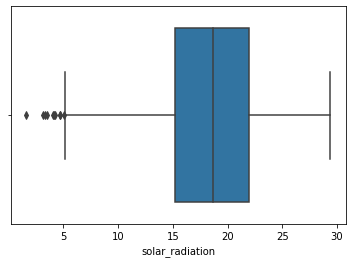

In [22]:
sns.boxplot(df['solar_radiation'])

In [23]:
df.drop(df[df['solar_radiation'] < 5].index, inplace = True)

Since there is a large amount of faulty measurement in year 2014, while the entire data in year 2015 is incomplete.<br>
Hence, we don't do machine learning training in year 2014 onwards.

In [24]:
df.drop(df[df['year'] >= 2014].index, inplace = True)

Log transformation is used on <code>mean_wind</code> in order to reduce the skewness.
The result is shown below.

In [25]:
print("skewness of mean_wind before ", df['mean_wind'].skew())
df['mean_wind'] = np.log(df['mean_wind'])
print("skewness of mean_wind after log transformation", df['mean_wind'].skew())

skewness of mean_wind before  0.39079321083172525
skewness of mean_wind after log transformation -0.28454785037088803


We also exclude no rainfall as for zero-inflated problem that result in highly imbalanced dataset. <br>
Hence, we only focus on rainfall amount instead of determine through the presence of raining in that particular day.

In [26]:
df.drop(df[df['rainfall'] == 0].index, inplace = True)
df.drop(df[df['rainfall_pj'] == 0].index, inplace = True)
df.reset_index(inplace = True, drop=True)

Log transformation is used on <code>rainfall</code> and <code>rainfall_pj</code> in order to reduce the skewness.
The result is shown below.

In [27]:
df['rainfall'] = np.log(df['rainfall'])
df['rainfall_pj'] = np.log(df['rainfall_pj'])
print("Skewness of 'rainfall' \t\t:", df['rainfall'].skew())
print("Skewness of 'rainfall_pj' \t:", df['rainfall_pj'].skew())

Skewness of 'rainfall' 		: -0.5341887812884516
Skewness of 'rainfall_pj' 	: -0.5789922635282985


We observed that the rainfall data is highly right skewed. <br>
After log transformation, the rainfall data is normalized.

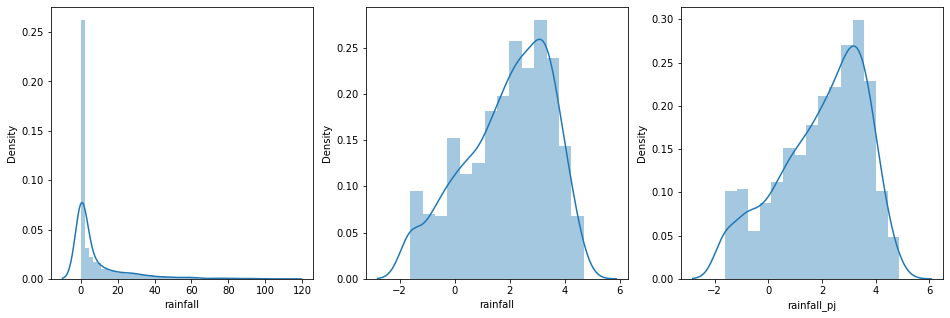

In [28]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
sns.distplot(df_sb['rainfall'])
plt.subplot(1,3,2)
sns.distplot(df['rainfall'])
plt.subplot(1,3,3)
sns.distplot(df['rainfall_pj'])
plt.show()

As well as for boxplots for rainfall data in both station.

<AxesSubplot:xlabel='variable', ylabel='value'>

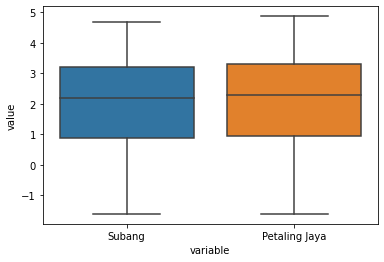

In [50]:
df_rainfall = pd.DataFrame(data = np.array([df['rainfall'], df['rainfall_pj']]).T, columns = ['Subang','Petaling Jaya'])
sns.boxplot(x="variable", y="value", data=pd.melt(df_rainfall))

The skewness of all attribute in the dataset. In between -1 and 1 to be considered as low skewness.

In [30]:
df.skew()

year               0.022870
month             -0.049382
day               -0.007815
rainfall          -0.534189
mean_wind         -0.294433
solar_radiation   -0.057661
rainfall_pj       -0.578992
dtype: float64

## More on Feature Engineering

Define new column <code>week</code>.

In [31]:
from datetime import date

date = ['year', 'month', 'day']
df['date'] = df[date].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['week'] = df['date'].dt.week

Define new columns <br>
<code>mean_month</code> : Mean of the particular month<br>
<code>mean_year</code> : Mean of the particular year<br>
<code>max_month</code> : Maximum of the particular month<br>
<code>max_year</code> : Maximum of the particular month

In [32]:
rainfall_month_mean = df.groupby(["year","month"]).mean()['rainfall']
rainfall_year_mean = df.groupby(["year"]).mean()['rainfall']

rainfall_month_max = df.groupby(["year","month"]).max()['rainfall']
rainfall_year_max = df.groupby(["year"]).max()['rainfall']

df['mean_month'] = np.nan
df['mean_year'] = np.nan
df['max_month'] = np.nan
df['max_year'] = np.nan

ind1, ind2 = 0, 0

for year in df['year'].unique():
    df.loc[df['year'] == year, 'mean_year'] = rainfall_year_mean.iloc[ind1]
    df.loc[df['year'] == year, 'max_year'] = rainfall_year_max.iloc[ind1]
    ind1 += 1
    
    for month in df['month'].unique():
        df.loc[(df['year'] == year) & (df['month'] == month) , 'mean_month'] = rainfall_month_mean.iloc[ind2]
        df.loc[(df['year'] == year) & (df['month'] == month) , 'max_month'] = rainfall_month_max.iloc[ind2]
        ind2 += 1

## Feature Extraction

### Unsupervised Learning (K-means)

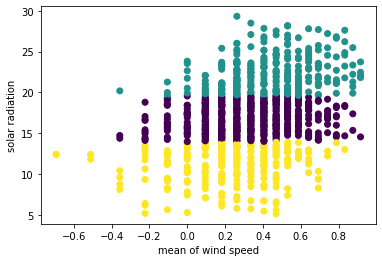

In [33]:
## Kmeans Clustering
from sklearn.cluster import KMeans

kmn1 = KMeans(n_clusters=3)
kmn1.fit(df[['mean_wind','solar_radiation']])
wind_solar = kmn1.predict(df[['mean_wind','solar_radiation']])
df['cluster1'] = wind_solar

cluster1x = df['mean_wind']
cluster1y = df['solar_radiation']

plt.xlabel("mean of wind speed")
plt.ylabel("solar radiation")
plt.scatter(cluster1x, cluster1y, c= wind_solar)
plt.show()

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.

In [34]:
inertia_list1 = []
for k in np.arange(1, 10):
    kmn1 = KMeans(n_clusters=k)
    kmn1.fit(df[['mean_wind','solar_radiation']])
    inertia_list1.append(kmn1.inertia_)
    
for i in range(1,10):
    print(i, ":", inertia_list1[i-1])

1 : 21319.937372570083
2 : 7619.258006079774
3 : 3920.0779857499415
4 : 2330.26632329338
5 : 1624.6061193417174
6 : 1126.8104636581113
7 : 866.7312070811533
8 : 687.9736249331789
9 : 541.5328151905103


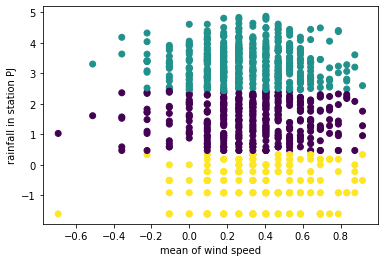

In [35]:
kmn2 = KMeans(n_clusters=3)
kmn2.fit(df[['mean_wind','rainfall_pj']])
wind_pj = kmn2.predict(df[['mean_wind','rainfall_pj']])
df['cluster2'] = wind_pj

cluster2x = df['mean_wind']
cluster2y = df['rainfall_pj']

plt.xlabel("mean of wind speed")
plt.ylabel("rainfall in station PJ")
plt.scatter(cluster2x, cluster2y, c= wind_pj)
plt.show()

In [36]:
inertia_list2 = []
for k in np.arange(1, 10):
    kmn2 = KMeans(n_clusters=k)
    kmn2.fit(df[['mean_wind','rainfall_pj']])
    inertia_list2.append(kmn2.inertia_)
    
for i in range(1,10):
    print(i, ":", inertia_list2[i-1])

1 : 2790.759114507706
2 : 834.1731802133379
3 : 425.5560153423495
4 : 269.8793945168299
5 : 199.72874497593708
6 : 159.01507219742732
7 : 135.1665913290769
8 : 116.20031948576067
9 : 103.96091395767075


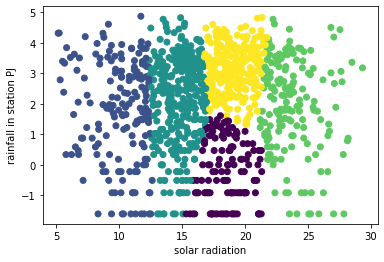

In [37]:
kmn3 = KMeans(n_clusters=5)
kmn3.fit(df[['solar_radiation','rainfall_pj']])
solar_pj = kmn3.predict(df[['solar_radiation','rainfall_pj']])
df['cluster3'] = solar_pj

cluster3x = df['solar_radiation']
cluster3y = df['rainfall_pj']

plt.xlabel("solar radiation")
plt.ylabel("rainfall in station PJ")
plt.scatter(cluster3x, cluster3y, c= solar_pj)
plt.show()

In [38]:
inertia_list3 = []
for k in np.arange(1, 10):
    kmn3 = KMeans(n_clusters=k)
    kmn3.fit(df[['solar_radiation','rainfall_pj']])
    inertia_list3.append(kmn3.inertia_)
    
for i in range(1,10):
    print(i, ":", inertia_list3[i-1])

1 : 23984.22430467526
2 : 10276.676914555439
3 : 6578.108929315642
4 : 4986.269542244158
5 : 4166.292006225497
6 : 3428.844422419017
7 : 2932.7454096860097
8 : 2531.39784446711
9 : 2262.79731836902


Spliting non-missing and missing rainfall data.

In [39]:
df_miss = df[df['rainfall'].isna()]
df_nonmiss = df[df['rainfall'].notna()]

Categoriztion. The binning of rainfall amount is based on the categorization provided by Malaysia Meteorological Department

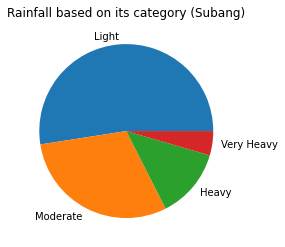

In [40]:
cats = ['Light', 'Moderate', 'Heavy', 'Very Heavy']
cats_values = [0, 10, 30, 60]
cats_log = np.log(cats_values)

rain1 = (df['rainfall'] > cats_log[0]) & (df['rainfall'] <= cats_log[1])
rain2 = (df['rainfall'] > cats_log[1]) & (df['rainfall'] <= cats_log[2])
rain3 = (df['rainfall'] > cats_log[2]) & (df['rainfall'] <= cats_log[3])
rain4 = df['rainfall'] > cats_log[3]

# Create category column
df_nonmiss['rainfall_cat'] = np.nan
df_nonmiss.loc[rain1, 'rainfall_cat'] = cats[0]
df_nonmiss.loc[rain2, 'rainfall_cat'] = cats[1]
df_nonmiss.loc[rain3, 'rainfall_cat'] = cats[2]
df_nonmiss.loc[rain4, 'rainfall_cat'] = cats[3]

amount = [rain1.values.sum(),
          rain2.values.sum(),
          rain3.values.sum(),
          rain4.values.sum()]
plt.pie(amount, labels = cats)
plt.title("Rainfall based on its category (Subang)")
plt.show()

## Feature Selection

Find the Pearson's correlation in between attributes / columns.

<AxesSubplot:>

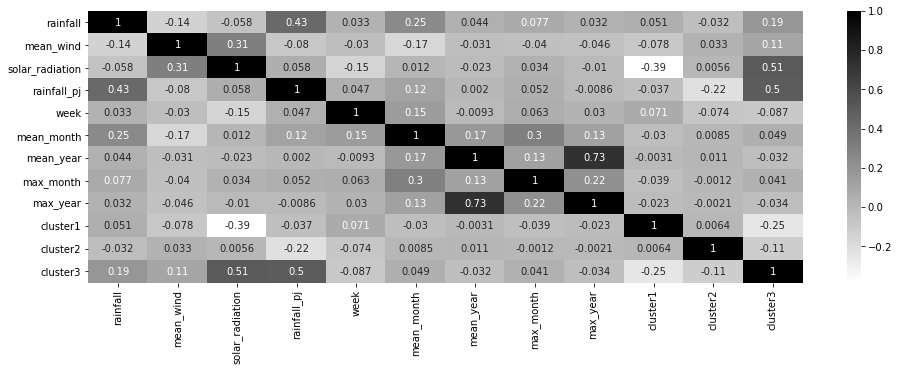

In [41]:
corr = df_nonmiss.corr()
plt.figure(figsize = (16,5))
sns.heatmap(corr,cmap='binary', xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

Pairplot visualizes given data to find the relationship between them where the variables can be continuous or categorical.

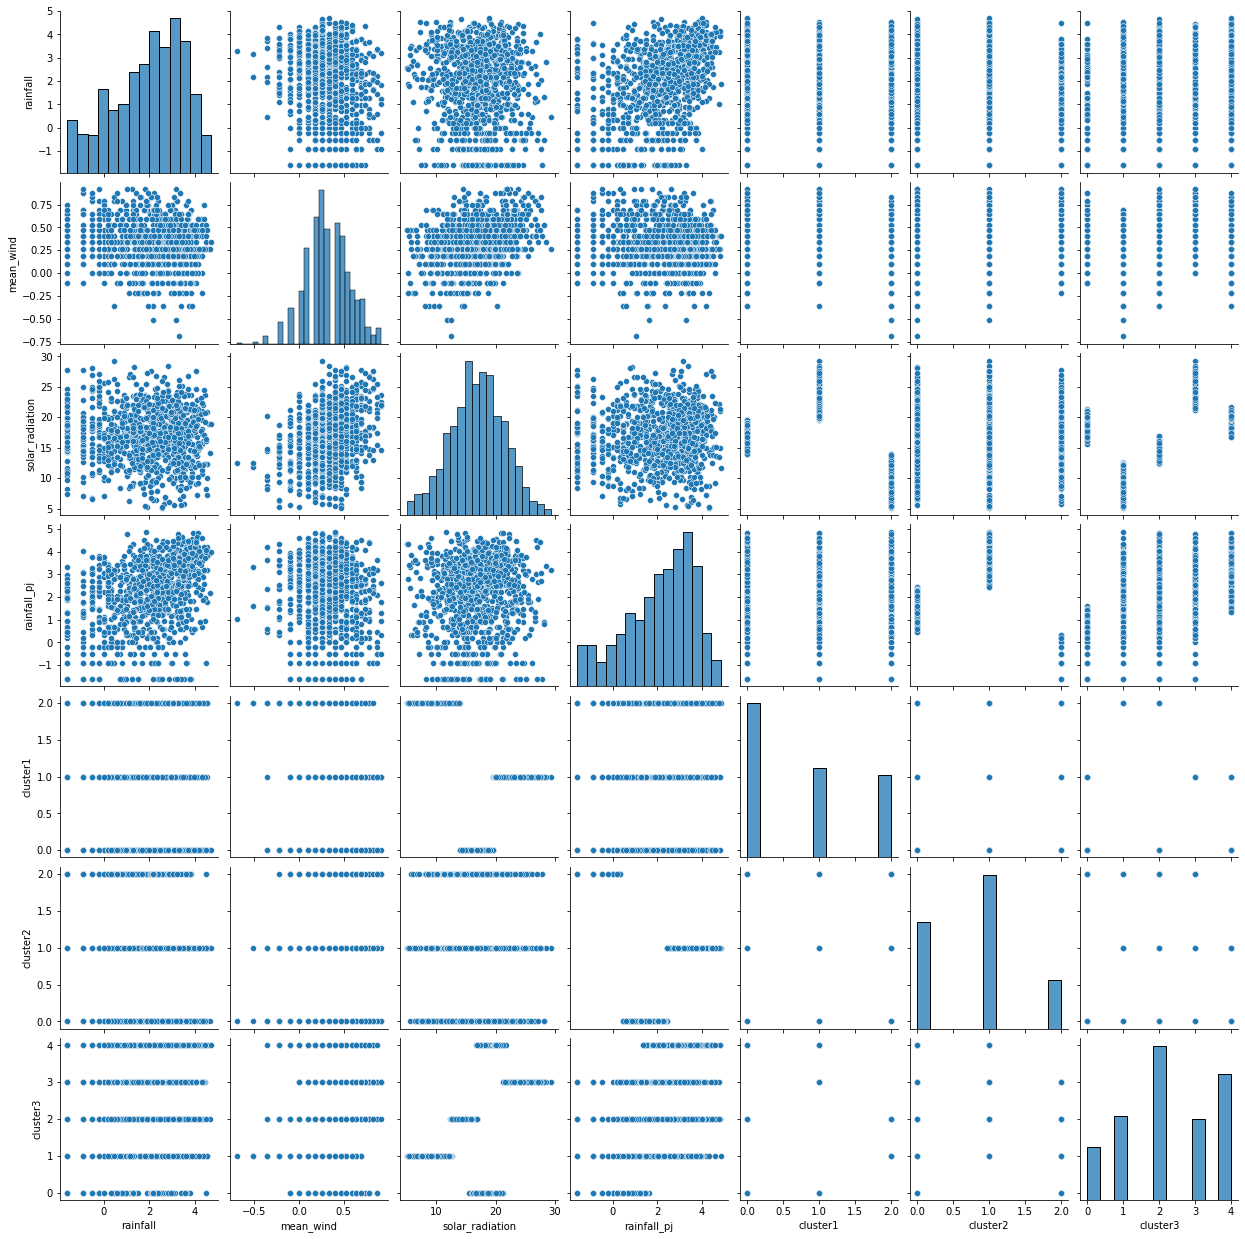

In [42]:
sns.pairplot(df_nonmiss[['rainfall','mean_wind','solar_radiation','rainfall_pj','cluster1','cluster2','cluster3']])

We choose threshold correlation be X > |corr|, for corr = 0, 0.2, 0.4.

In [43]:
features = corr.columns[(corr['rainfall'] > 0)|(corr['rainfall'] < -0)][1:]

# 2. Machine Learning

# 2.1 Overall Case

## Train Test Split

In [44]:
X = df_nonmiss[features]
y = df_nonmiss['rainfall']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Stardardscaler

Standardize features by removing the mean and scaling to unit variance.

In [45]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

## GridSearch CV

Exhaustive search over specified parameter values for an estimator. Important members are fit, predict.

In [46]:
from sklearn.model_selection import GridSearchCV

dt_params = [{'max_depth': list(range(1, 5)), 'max_features': list(range(1, 5))}]
rf_params = [{'max_depth': list(range(1, 5)), 'max_features': list(range(1, 5))}]
knn_params = [{'n_neighbors': list(range(1, 10)),
               'weights': ['uniform', 'distance'],
               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}]
ann_params = [{'max_iter': [50, 100, 150],
               'hidden_layer_sizes': [(32, 16),(16, 16), (32, 32)],
               'activation': ['identity','softmax','relu'],
               'early_stopping': [True, False]}]

## Decision Tree

In [47]:
from sklearn.tree import DecisionTreeRegressor

## GridSearch Params
DT = DecisionTreeRegressor()
DT_Grid = GridSearchCV(DT, dt_params, cv = 5, scoring = 'neg_root_mean_squared_error').fit(X_train_scaled, y_train)
print("Hyperparameters for Decision Tree is", DT_Grid.best_params_)

## Tuning Params
DT = DecisionTreeRegressor(max_depth = DT_Grid.best_params_['max_depth'],
                           max_features = DT_Grid.best_params_['max_features']).fit(X_train_scaled, y_train)

## Predict
dt_y_pred = DT.predict(X_test_scaled)

Hyperparameters for Decision Tree is {'max_depth': 3, 'max_features': 3}


## Random Forest

In [48]:
from sklearn.ensemble import RandomForestRegressor

## GridSearch Params
RF = RandomForestRegressor()
RF_Grid = GridSearchCV(RF, rf_params, cv = 5, scoring = 'neg_root_mean_squared_error').fit(X_train_scaled, y_train)
print("Hyperparameters for Random Forest is", RF_Grid.best_params_)

## Tuning Params
RF = RandomForestRegressor(max_depth = RF_Grid.best_params_['max_depth'],
                           max_features = RF_Grid.best_params_['max_features']).fit(X_train_scaled, y_train)

# Predict 
rf_y_pred = RF.predict(X_test_scaled)

Hyperparameters for Random Forest is {'max_depth': 4, 'max_features': 4}


## K-nearest Neighbors

In [49]:
from sklearn.neighbors import KNeighborsRegressor

## GridSearch Params
KNN = KNeighborsRegressor()
KNN_Grid = GridSearchCV(KNN, knn_params, cv = 5, scoring = 'neg_root_mean_squared_error').fit(X_train_scaled, y_train)
print("Hyperparameters for K-nearest Neighbors is", KNN_Grid.best_params_)

## Tuning Params
KNN = KNeighborsRegressor(n_neighbors = KNN_Grid.best_params_['n_neighbors'],
                          weights = KNN_Grid.best_params_['weights'],
                          algorithm = KNN_Grid.best_params_['algorithm']).fit(X_train_scaled, y_train)

## Predict
knn_y_pred = KNN.predict(X_test_scaled)

Hyperparameters for K-nearest Neighbors is {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}


## Artificial Neural Network

In [50]:
from sklearn.neural_network import MLPRegressor

## GridSearch Params
ANN = MLPRegressor()
ANN_Grid = GridSearchCV(ANN, ann_params, cv = 5, scoring = 'neg_root_mean_squared_error').fit(X_train_scaled, y_train)
print("Hyperparameters for Artificial Neural Network is\n", ANN_Grid.best_params_)

## Tuning Params
ANN = MLPRegressor(max_iter = ANN_Grid.best_params_['max_iter'],
                   hidden_layer_sizes = ANN_Grid.best_params_['hidden_layer_sizes'],
                   activation = ANN_Grid.best_params_['activation'],
                   early_stopping = ANN_Grid.best_params_['early_stopping'],
                   solver = 'adam',
                  ).fit(X_train_scaled, y_train)


## Predict
ann_y_pred = ANN.predict(X_test_scaled)

Hyperparameters for Artificial Neural Network is
 {'activation': 'identity', 'early_stopping': True, 'hidden_layer_sizes': (32, 32), 'max_iter': 50}


## Model Evaluation

3 regression metrics use is root mean squared error, mean absolute error, and r squared.

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def MAE(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def R2(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [52]:
metric = pd.DataFrame(index = ['Decision Tree', 'Random Forest', 'K-nearest Neighbor', 'Artificial Neural Networks'], 
                      columns = ['RMSE Training', 'RMSE Predict', 'MAE', 'R2'])

metric.loc['Decision Tree'] = [-DT_Grid.best_score_, RMSE(y_test, dt_y_pred), MAE(y_test, dt_y_pred), R2(y_test, dt_y_pred)]
metric.loc['Random Forest'] = [-RF_Grid.best_score_, RMSE(y_test, rf_y_pred), MAE(y_test, rf_y_pred), R2(y_test, rf_y_pred)]
metric.loc['K-nearest Neighbor'] = [-KNN_Grid.best_score_, RMSE(y_test, knn_y_pred), MAE(y_test, knn_y_pred), R2(y_test, knn_y_pred)]
metric.loc['Artificial Neural Networks'] = [-ANN_Grid.best_score_, RMSE(y_test, ann_y_pred), MAE(y_test, ann_y_pred), R2(y_test, ann_y_pred)]

metric

,RMSE Training,RMSE Predict,MAE,R2
Decision Tree,1.45787,1.46228,1.19498,0.168481
Random Forest,1.38404,1.42531,1.15493,0.209988
K-nearest Neighbor,1.46279,1.47628,1.20135,0.152482
Artificial Neural Networks,1.38049,1.39216,1.10703,0.246317


## Model Imputation

In [53]:
# Sorting based on actual rainfall amount
order_ind = np.argsort(y_test)
y_test.sort_values(ascending=True, inplace=True)

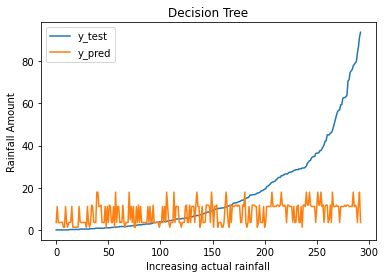

In [54]:
# Decision tree model predicted rainfall
dt_y_pred = DT.predict(X_test_scaled)

plt.plot(range(len(y_test)), np.exp(y_test), label = "y_test")
plt.plot(range(len(y_test)), np.exp(dt_y_pred[order_ind.tolist()]), label = "y_pred")
plt.title("Decision Tree")
plt.xlabel("Increasing actual rainfall")
plt.ylabel("Rainfall Amount")
plt.legend()
plt.show()

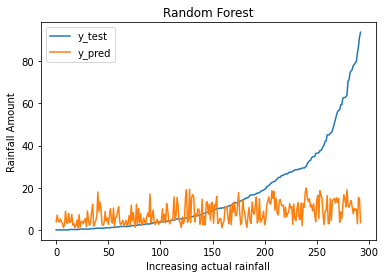

In [55]:
# Random forest model predicted rainfall
rf_y_pred = RF.predict(X_test_scaled)

plt.plot(range(len(y_test)), np.exp(y_test), label = "y_test")
plt.plot(range(len(y_test)), np.exp(rf_y_pred[order_ind.tolist()]), label = "y_pred")
plt.title("Random Forest")
plt.xlabel("Increasing actual rainfall")
plt.ylabel("Rainfall Amount")
plt.legend()
plt.show()

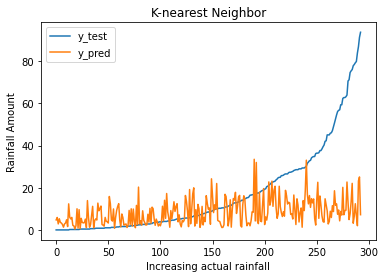

In [56]:
# K-nearest neighbor model predicted rainfall
knn_y_pred = KNN.predict(X_test_scaled)

plt.plot(range(len(y_test)), np.exp(y_test), label = "y_test")
plt.plot(range(len(y_test)), np.exp(knn_y_pred[order_ind.tolist()]), label = "y_pred")
plt.title("K-nearest Neighbor")
plt.xlabel("Increasing actual rainfall")
plt.ylabel("Rainfall Amount")
plt.legend()
plt.show()

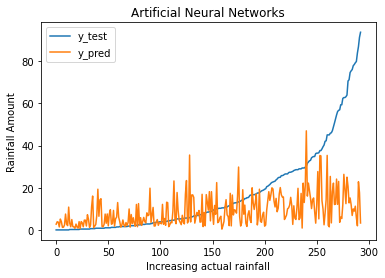

In [57]:
# Artificial neural network model predicted rainfall
ann_y_pred = ANN.predict(X_test_scaled)

plt.plot(range(len(y_test)), np.exp(y_test), label = "y_test")
plt.plot(range(len(y_test)), np.exp(ann_y_pred[order_ind.tolist()]), label = "y_pred")
plt.title("Artificial Neural Networks")
plt.xlabel("Increasing actual rainfall")
plt.ylabel("Rainfall Amount")
plt.legend()
plt.show()

# 2.2 South-west Monsoon Case

In [58]:
dfM_nonmiss = df_nonmiss.copy()
dfM_nonmiss.drop(dfM_nonmiss[(dfM_nonmiss['month']>9)|(dfM_nonmiss['month']<5)].index, inplace = True)

# Month May until end of October
XM = dfM_nonmiss[features[1:]]
yM = dfM_nonmiss['rainfall']

In [59]:
## Train, test and split
from sklearn.model_selection import train_test_split
XM_train, XM_test, yM_train, yM_test = train_test_split(XM, yM, test_size=0.3)

## Standardscaler

In [60]:
## Standard scaler
XM_train_scaled = sc.fit_transform(XM_train)
XM_test_scaled = sc.transform(XM_test)

## Decision Tree

In [61]:
## GridSearch Params
DTM = DecisionTreeRegressor()
DTM_Grid = GridSearchCV(DTM, dt_params, cv = 5, scoring = 'neg_root_mean_squared_error').fit(XM_train_scaled, yM_train)
print("Hyperparameters for Decision Tree is", DTM_Grid.best_params_)

## Tuning Params
DTM = DecisionTreeRegressor(max_depth = DTM_Grid.best_params_['max_depth'],
                            max_features = DTM_Grid.best_params_['max_features']).fit(XM_train_scaled, yM_train)

## Predict
dtM_y_pred = DTM.predict(XM_test_scaled)

Hyperparameters for Decision Tree is {'max_depth': 2, 'max_features': 3}


## Random Forest

In [62]:
## GridSearch Params
RFM = RandomForestRegressor()
RFM_Grid = GridSearchCV(RFM, rf_params, cv = 5, scoring = 'neg_root_mean_squared_error').fit(XM_train_scaled, yM_train)
print("Hyperparameters for Random Forest is", RFM_Grid.best_params_)

## Tuning Params
RFM = DecisionTreeRegressor(max_depth = RFM_Grid.best_params_['max_depth'],
                            max_features = RFM_Grid.best_params_['max_features']).fit(XM_train_scaled, yM_train)

## Predict
rfM_y_pred = RFM.predict(XM_test_scaled)

Hyperparameters for Random Forest is {'max_depth': 3, 'max_features': 4}


## K-nearest Neighbors

In [63]:
## GridSearch Params
KNNM = KNeighborsRegressor()
KNNM_Grid = GridSearchCV(KNNM, knn_params, cv = 5, scoring = 'neg_root_mean_squared_error').fit(XM_train_scaled, yM_train)
print("Hyperparameters for K-nearest Neighbors is", KNNM_Grid.best_params_)

## Tuning Params
KNNM = KNeighborsRegressor(n_neighbors = KNNM_Grid.best_params_['n_neighbors'],
                           weights = KNNM_Grid.best_params_['weights'],
                           algorithm = KNNM_Grid.best_params_['algorithm']).fit(XM_train_scaled, yM_train)

## Predict
knnM_y_pred = KNNM.predict(XM_test_scaled)

Hyperparameters for K-nearest Neighbors is {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}


## Artificial neural networks

In [64]:
## GridSearch Params
ANNM = MLPRegressor()
ANNM_Grid = GridSearchCV(ANNM, ann_params, cv = 5, scoring = 'neg_root_mean_squared_error').fit(XM_train_scaled, yM_train)
print("Hyperparameters for Artificial neural networks is\n", ANNM_Grid.best_params_)

## Tuning Params
ANNM = MLPRegressor(max_iter = ANNM_Grid.best_params_['max_iter'],
                   hidden_layer_sizes = ANNM_Grid.best_params_['hidden_layer_sizes'],
                   activation = ANNM_Grid.best_params_['activation'],
                   early_stopping = ANNM_Grid.best_params_['early_stopping'],
                   solver = 'adam',
                  ).fit(XM_train_scaled, yM_train)

## Inference
annM_y_pred = ANNM.predict(XM_test_scaled)

Hyperparameters for Artificial neural networks is
 {'activation': 'identity', 'early_stopping': True, 'hidden_layer_sizes': (32, 32), 'max_iter': 50}


## Model Evaluation

In [65]:
metric = pd.DataFrame(index = ['Decision Tree', 'Random Forest', 'K-nearest Neighbor', 'Artificial Neural Networks'], 
                      columns = ['RMSE Training', 'RMSE Predict', 'MAE', 'R2'])

metric.loc['Decision Tree'] = [-DTM_Grid.best_score_, RMSE(y_test, dt_y_pred), MAE(y_test, dt_y_pred), R2(y_test, dt_y_pred)]
metric.loc['Random Forest'] = [-RFM_Grid.best_score_, RMSE(y_test, rf_y_pred), MAE(y_test, rf_y_pred), R2(y_test, rf_y_pred)]
metric.loc['K-nearest Neighbor'] = [-KNNM_Grid.best_score_, RMSE(y_test, knn_y_pred), MAE(y_test, knn_y_pred), R2(y_test, knn_y_pred)]
metric.loc['Artificial Neural Networks'] = [-ANNM_Grid.best_score_, RMSE(y_test, ann_y_pred), MAE(y_test, ann_y_pred), R2(y_test, ann_y_pred)]

metric

,RMSE Training,RMSE Predict,MAE,R2
Decision Tree,1.42543,1.74186,1.43226,-0.179884
Random Forest,1.39276,1.72137,1.40113,-0.152283
K-nearest Neighbor,1.46478,1.75855,1.41442,-0.2026
Artificial Neural Networks,1.37993,1.81474,1.47332,-0.280687


# 2.3 Classification Case

## Train Test Split

In [66]:
XC = df_nonmiss[features[1:]]
yC = df_nonmiss['rainfall_cat']
XC_train, XC_test, yC_train, yC_test = train_test_split(XC, yC, test_size=0.3)

Classification metrics used is confusion matrix and classfication report.

In [67]:
from sklearn.metrics import plot_confusion_matrix, classification_report

## Decision Tree

Hyperparameters for Decision Tree is {'max_depth': 1, 'max_features': 3}
with the training acurracy of 0.5577930442249892


              precision    recall  f1-score   support

       Heavy       0.00      0.00      0.00        39
       Light       0.56      0.79      0.65       149
    Moderate       0.37      0.33      0.35        92
  Very Heavy       0.00      0.00      0.00        13

    accuracy                           0.51       293
   macro avg       0.23      0.28      0.25       293
weighted avg       0.40      0.51      0.44       293



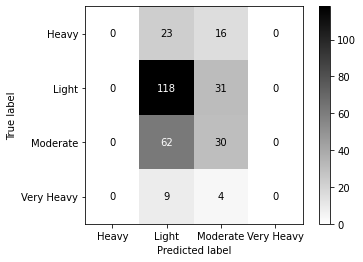

In [68]:
from sklearn.tree import DecisionTreeClassifier

## GridSearch Params
DTC = DecisionTreeClassifier()
DTC_Grid = GridSearchCV(DTC, dt_params, cv = 5, scoring = 'accuracy').fit(XC_train, yC_train)
print("Hyperparameters for Decision Tree is", DTC_Grid.best_params_)
print("with the training acurracy of", DTC_Grid.best_score_)
print("\n")

## Tuning Params
DTC = DecisionTreeClassifier(max_depth = DTC_Grid.best_params_['max_depth'],
                             max_features = DTC_Grid.best_params_['max_features']).fit(XC_train, yC_train)
 
## Predict
dtC_y_pred = DTC.predict(XC_test)
print(classification_report(yC_test, dtC_y_pred))
plot_confusion_matrix(DTC, XC_test, yC_test, cmap='binary')

## Random Forest

Hyperparameters for Random Forest is {'max_depth': 4, 'max_features': 4}
with the training acurracy of 0.5739158437097467


              precision    recall  f1-score   support

       Heavy       0.40      0.05      0.09        39
       Light       0.58      0.75      0.66       149
    Moderate       0.33      0.35      0.34        92
  Very Heavy       0.00      0.00      0.00        13

    accuracy                           0.50       293
   macro avg       0.33      0.29      0.27       293
weighted avg       0.45      0.50      0.45       293



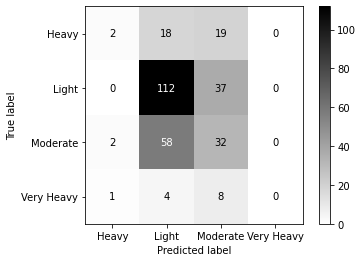

In [69]:
from sklearn.ensemble import RandomForestClassifier

## GridSearch Params
RFC = RandomForestClassifier()
RFC_Grid = GridSearchCV(RFC, rf_params, cv = 5, scoring = 'accuracy').fit(XC_train, yC_train)
print("Hyperparameters for Random Forest is", RFC_Grid.best_params_)
print("with the training acurracy of", RFC_Grid.best_score_)
print("\n")

## Tuning Params
RFC = RandomForestClassifier(max_depth = RFC_Grid.best_params_['max_depth'],
                             max_features = RFC_Grid.best_params_['max_features']).fit(XC_train, yC_train)
 
## Predict
rfC_y_pred = RFC.predict(XC_test)
print(classification_report(yC_test, rfC_y_pred))
plot_confusion_matrix(RFC, XC_test, yC_test, cmap='binary')

## K-nearest Neighbor

Hyperparameters for K-nearest Neighbor is {'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'uniform'}
with the training acurracy of 0.5446972949763846


              precision    recall  f1-score   support

       Heavy       0.38      0.13      0.19        39
       Light       0.60      0.82      0.69       149
    Moderate       0.42      0.35      0.38        92
  Very Heavy       0.00      0.00      0.00        13

    accuracy                           0.54       293
   macro avg       0.35      0.32      0.32       293
weighted avg       0.49      0.54      0.50       293



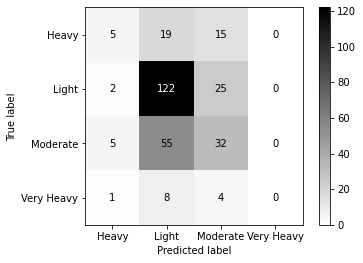

In [70]:
from sklearn.neighbors import KNeighborsClassifier

## GridSearch Params
KNNC = KNeighborsClassifier()
KNNC_Grid = GridSearchCV(KNNC, knn_params, cv = 5, scoring = 'accuracy').fit(XC_train, yC_train)
print("Hyperparameters for K-nearest Neighbor is", KNNC_Grid.best_params_)
print("with the training acurracy of", KNNC_Grid.best_score_)
print("\n")

## Tuning Params
KNNC = KNeighborsClassifier(n_neighbors = KNNC_Grid.best_params_['n_neighbors'],
                            weights = KNNC_Grid.best_params_['weights'],
                            algorithm = KNNC_Grid.best_params_['algorithm']).fit(XC_train, yC_train)
 
## Predict
knnC_y_pred = KNNC.predict(XC_test)
print(classification_report(yC_test, knnC_y_pred))
plot_confusion_matrix(KNNC, XC_test, yC_test, cmap='binary')

## Artificial Neural Network

Hyperparameters for Artificial Neural Network is {'activation': 'identity', 'early_stopping': False, 'hidden_layer_sizes': (32, 16), 'max_iter': 100}
with the training acurracy of 0.5812151137827394


              precision    recall  f1-score   support

       Heavy       0.00      0.00      0.00        39
       Light       0.56      0.86      0.68       149
    Moderate       0.34      0.24      0.28        92
  Very Heavy       0.00      0.00      0.00        13

    accuracy                           0.51       293
   macro avg       0.22      0.27      0.24       293
weighted avg       0.39      0.51      0.43       293



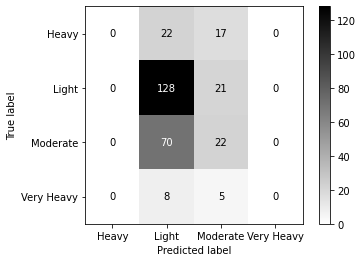

In [71]:
from sklearn.neural_network import MLPClassifier

## GridSearch Params
ANNC = MLPClassifier()
ANNC_Grid = GridSearchCV(ANNC, ann_params, cv = 5, scoring = 'accuracy').fit(XC_train, yC_train)
print("Hyperparameters for Artificial Neural Network is", ANNC_Grid.best_params_)
print("with the training acurracy of", ANNC_Grid.best_score_)
print("\n")

## Tuning Params
ANNC = MLPClassifier(max_iter = ANNC_Grid.best_params_['max_iter'],
                     hidden_layer_sizes = ANNC_Grid.best_params_['hidden_layer_sizes'],
                     activation = ANNC_Grid.best_params_['activation'],
                     early_stopping = ANNC_Grid.best_params_['early_stopping'],
                     solver = 'adam',
                    ).fit(XC_train, yC_train)


annC_y_pred = ANNC.predict(XC_test)
print(classification_report(yC_test, annC_y_pred))
plot_confusion_matrix(ANNC, XC_test, yC_test, cmap='binary')

# 3. Imputation

The best model chosen is Artificial neural network with the highest accuracy in all cases.

In [72]:
missing_ind = list(df_miss.index)
X_miss = df_miss[features]
impute = ANN.predict(X_miss)

df_imputed = df.copy()

for i in missing_ind:
    for j in range(sum(df['rainfall'].isna())):
        df_imputed.at[i,'rainfall'] = impute[j]

Comparison of non-missing rainfall data of both station and imputed rainfall data in year 2009.

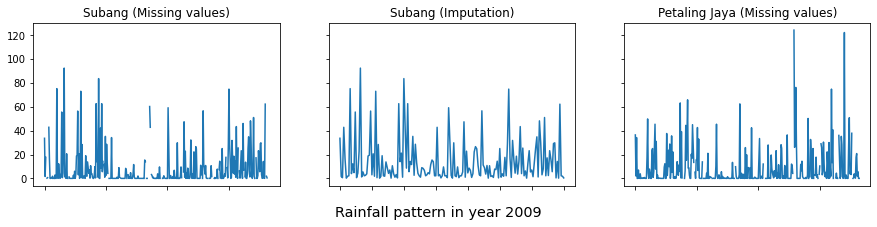

<Figure size 864x432 with 0 Axes>

In [73]:
df_sb_2009 = df_sb[df_sb['year'] == 2009]
impute_2009 = df_imputed[df_imputed['year'] == 2009]
df_pj_2009 = df_pj[df_pj['year'] == 2009]

f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

# Hide axis name
ax1.get_shared_y_axes().join(ax1, ax2, ax3)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])

# Name X axis
f.text(0.5, 0, 'Rainfall pattern in year 2009', ha='center', va='center', fontsize='x-large')

# Name Title
ax1.set_title("Subang (Missing values)")
ax2.set_title("Subang (Imputation)")
ax3.set_title("Petaling Jaya (Missing values)")

# Plot
ax1.plot(range(len(df_sb_2009)), df_sb_2009['rainfall'])
ax2.plot(range(len(impute_2009)), np.exp(impute_2009['rainfall']))
ax3.plot(range(len(df_pj_2009)), df_pj_2009['rainfall'])

plt.figure(figsize=(12, 6))
plt.show()

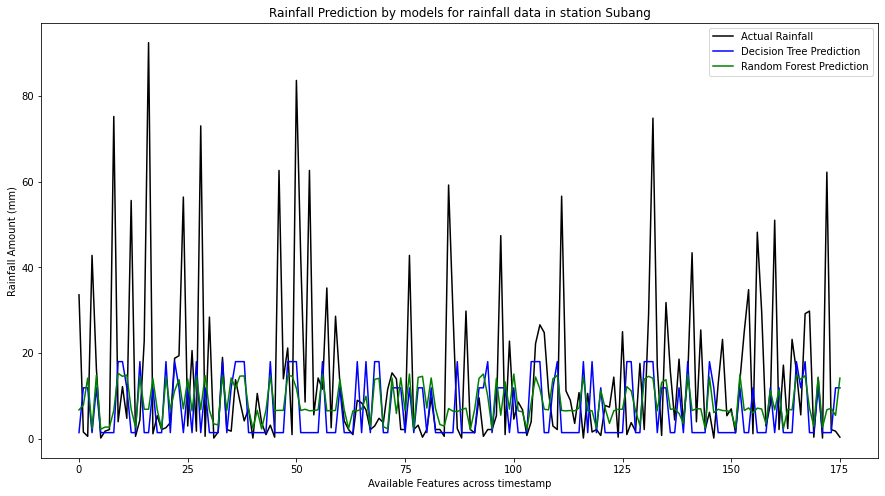

In [76]:
time = range(len(impute_2009))
features_2009 = impute_2009.loc[:, impute_2009.columns != 'rainfall'][features]

plt.plot(time, np.exp(impute_2009['rainfall']), 'k') 
plt.plot(time, np.exp(DT.predict(features_2009)), 'b') 
plt.plot(time, np.exp(RF.predict(features_2009)), 'g') 

plt.legend(['Actual Rainfall', 
            'Decision Tree Prediction', 
            'Random Forest Prediction'])
plt.rcParams["figure.figsize"] = (15,8)
plt.title("Rainfall Prediction by models for rainfall data in station Subang")
plt.xlabel("Available Features across timestamp")
plt.ylabel("Rainfall Amount (mm)")
plt.show()

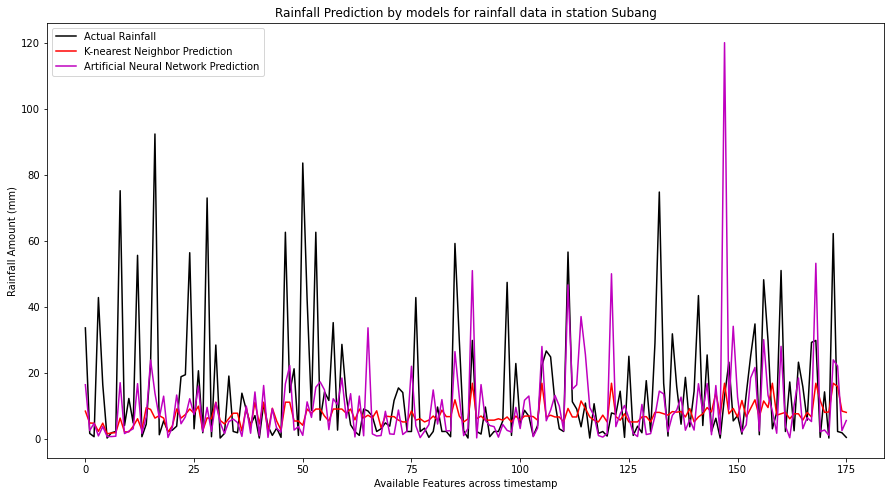

In [75]:
plt.plot(time, np.exp(impute_2009['rainfall']), 'k') 
plt.plot(time, np.exp(KNN.predict(features_2009)), 'r') 
plt.plot(time, np.exp(ANN.predict(features_2009)), 'm') 

plt.legend(['Actual Rainfall', 
            'K-nearest Neighbor Prediction',
            'Artificial Neural Network Prediction'])
plt.title("Rainfall Prediction by models for rainfall data in station Subang")
plt.xlabel("Available Features across timestamp")
plt.ylabel("Rainfall Amount (mm)")
plt.show()